# Option Pricing Analysis based on Words Per Minute (WPM) in HIMYM
(I definitely did not do this porject as an excuse to rewatch HIMYM)

## Introduction:

This notebook demonstrates the process of analyzing words per minute from subtitle files and using this data to perform some form of option pricing. The following steps are covered:
1. Data Preparation: Ensure consistent naming of files and extract data.
2. Data Aggregation: Combine data from multiple files.
3. Data Visualization: Plot the words per minute to visualize trends.
4. Data Modeling: Use ARIMA and polynomial regression to model the data.
5. Option Pricing: Estimate option pricing based on the modeled data.

## Part I: System Initialisation and Data Preparation

Before we do anything ensure that all the files have consistent naming

In [1]:
import os
import re
import pandas as pd
import numpy as np
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import norm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [2]:
#mute pandas warnings for cleaner ouput
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Create a function to change the names of the files in a folder

def rename_files_in_folder(folder_path):
    # Regular expression to match the season and episode numbers
    pattern = re.compile(r'S(\d{2})E(\d{2})')
    
    for filename in os.listdir(folder_path):
        # Extract season number from folder name
        season_number = folder_path.split(os.path.sep)[-1][1:3]
        
        # Check if filename matches the first pattern
        if filename[0:2].isdigit() and ' - ' in filename:
            episode_number = filename[0:2]
        # Check if filename matches the second pattern
        else:
            match = pattern.search(filename)
            if match:
                season_number, episode_number = match.groups()
            else:
                continue  # skip files that don't match any pattern
        
        # Construct the new filename
        new_filename = f'S{season_number}E{episode_number}.srt'
        os.rename(os.path.join(folder_path, filename), os.path.join(folder_path, new_filename))



In [4]:
#Itterate through all files in a folder and rename them

base_folder = os.path.join(os.getcwd(), 'sub_data')
for season_folder in os.listdir(base_folder):
    full_path = os.path.join(base_folder, season_folder)
    if os.path.isdir(full_path):  # Make sure it's a folder
        rename_files_in_folder(full_path)


## Part II: Data Aggregation

In this section, we aggregate the WPM data from different subtitle files to form a comprehensive dataset.

Define a function that will transform the data, such that we get the WPM per minute and we will use the minutes as the times of observation later i.e. it will all be one time trend

source of files: 
https://subdl.com/subtitle/sd1300117/how-i-met-your-mother

In [5]:
def wpm_per_minute(filename):
    def time_to_minutes(time_str):
        FMT = '%H:%M:%S,%f'
        t = datetime.strptime(time_str, FMT)
        return t.hour * 60 + t.minute + t.second / 60
    
    # Extract season and episode from filename
    pattern = re.compile(r'S(\d{2})E(\d{2})')
    match = pattern.search(os.path.basename(filename))
    if not match:
        raise ValueError("Filename does not match the expected format")
    season, episode = match.groups()

    # Try reading the file with different encodings
    encodings = ['utf-8', 'ISO-8859-1', 'windows-1252']
    for encoding in encodings:
        try:
            with open(filename, 'r', encoding=encoding) as file:
                lines = file.readlines()
            break
        except UnicodeDecodeError:
            pass
    else:
        raise UnicodeDecodeError(f"Failed to decode file {filename} with any of the tried encodings.")
        
    word_counts_per_minute = {}
    index = 0

    while index < len(lines):
        if not lines[index].strip():
            index += 1
            continue

        index += 1
        timestamp = lines[index].strip().split(' --> ')
        start_time = time_to_minutes(timestamp[0])
        end_time = time_to_minutes(timestamp[1])

        index += 1
        text = ''
        while index < len(lines) and lines[index].strip():
            text += lines[index]
            index += 1

        word_count = len(text.split())
        
        # Distribute word counts over minutes
        start_minute = int(start_time)
        end_minute = int(end_time)
        
        if start_minute == end_minute:
            word_counts_per_minute[(season, episode, start_minute)] = word_counts_per_minute.get((season, episode, start_minute), 0) + word_count
        else:
            for minute in range(start_minute, end_minute + 1):
                if minute == start_minute:
                    proportion = 1 - (start_time - start_minute)
                    word_counts_per_minute[(season, episode, minute)] = word_counts_per_minute.get((season, episode, minute), 0) + word_count * proportion
                elif minute == end_minute:
                    proportion = end_time - end_minute
                    word_counts_per_minute[(season, episode, minute)] = word_counts_per_minute.get((season, episode, minute), 0) + word_count * proportion
                else:
                    word_counts_per_minute[(season, episode, minute)] = word_counts_per_minute.get((season, episode, minute), 0) + word_count

        index += 1

    # Convert word counts to words per minute
    for key, count in word_counts_per_minute.items():
        word_counts_per_minute[key] = count  # It's already per minute

    df = pd.DataFrame(list(word_counts_per_minute.values()), index=pd.MultiIndex.from_tuples(word_counts_per_minute.keys(), names=['Season', 'Episode', 'Minute']), columns=['Words Per Minute'])

    return df


In [6]:
# Iterate over all season folders in the base folder

all_data = []

for season_folder in os.listdir(base_folder):
    season_folder_path = os.path.join(base_folder, season_folder)
    
    # Ensure it's a directory
    if os.path.isdir(season_folder_path):
        # Iterate over all files in the season folder
        for filename in os.listdir(season_folder_path):
            # Check if the file is an .srt file
            if filename.endswith('.srt'):
                file_path = os.path.join(season_folder_path, filename)
                df = wpm_per_minute(file_path)
                all_data.append(df)
    
# Concatenate all dataframes into one
df_all_eps = pd.concat(all_data)

Now let's transform it once again so that we have it as a time series. We will add a running index which will represent the cum minute.

In [7]:
# Resetting the multi-index to columns
df_reset = df_all_eps.reset_index()
    
# Sorting by Season, Episode, and Minute
df_sorted = df_reset.sort_values(by=['Season', 'Episode', 'Minute'])
    
# Create a global cumulative sum for the minutes to create a running total
df_sorted['Global Minute'] = range(len(df_sorted))
    
# Setting the 'Global Minute' as the new index
df_tseries = df_sorted.set_index('Global Minute')

In [8]:
df_tseries

,Season,Episode,Minute,Words Per Minute
Global Minute,,,,
0,01,01,0,166.116667
1,01,01,1,150.333333
2,01,01,2,173.166667
3,01,01,3,141.116667
4,01,01,4,141.000000
...,...,...,...,...
4545,09,24,17,107.050000
4546,09,24,18,150.166667
4547,09,24,19,114.066667


## Part III: Data Visualization and Analysis for trends

Visualizing the data helps in understanding trends and patterns. Here, we will plot the WPM data for different episodes.

I tried structuring the data in different ways, so that I would get sth interesting (I was really hoping to get some cyclical trend because I had just learned about the Ornstein–Uhlenbeck process and was looking to use it, however no matter what I did, no structure arose whatsoever)

First let's look at a single episode, maybe there is a trend there? and from what we see perhaps there is! So perhaps through each episode we get a sloping trend of WPM.

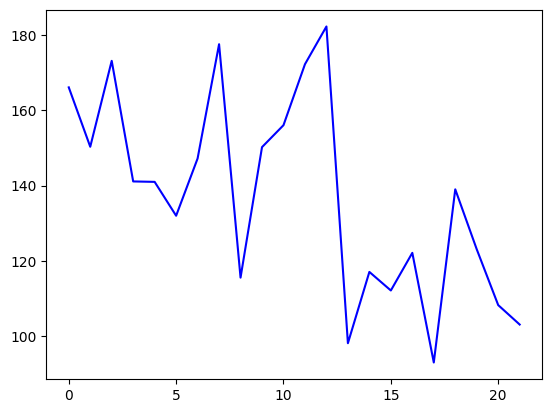

In [9]:
s1e1_data = df_tseries[(df_tseries['Season'] == '01') & (df_tseries['Episode'] == '01')]
plt.plot(s1e1_data['Minute'], s1e1_data['Words Per Minute'], label='Season 1 Episode 1', color='blue');


However, this is very misleading, because once we do all episodes we see that there is no such apparent trend

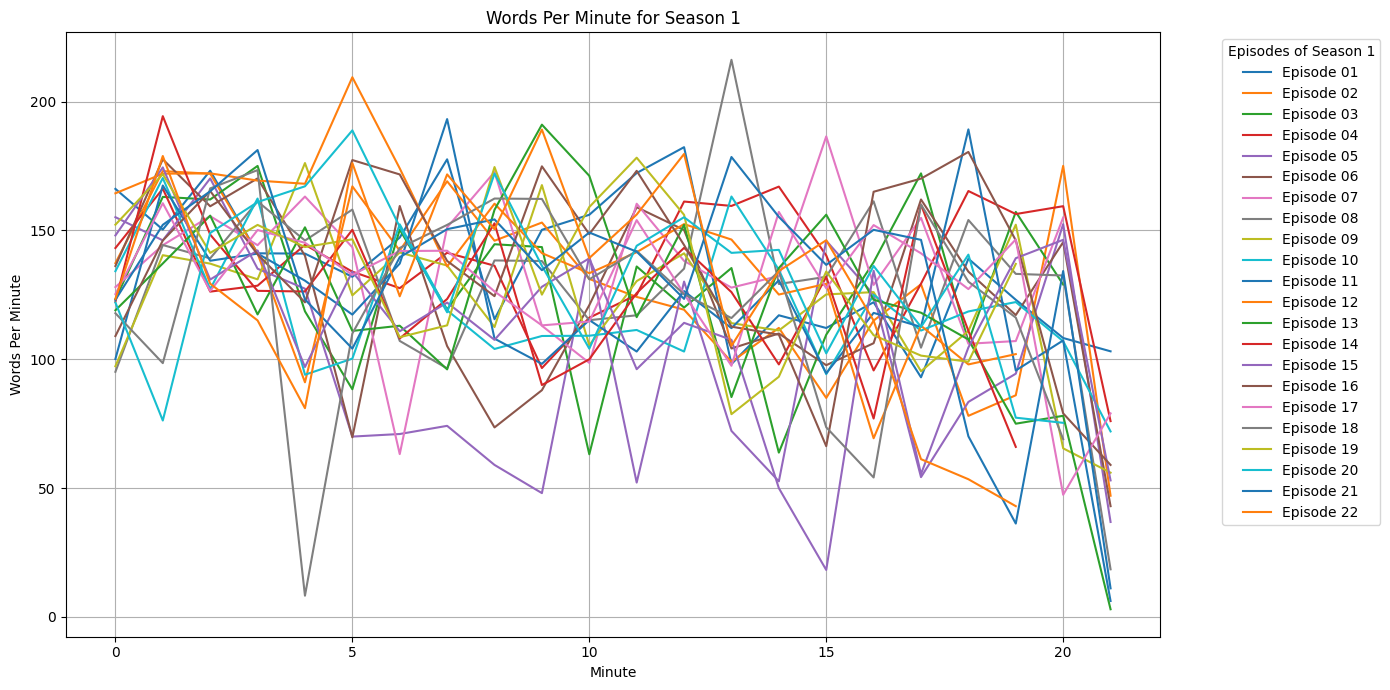

In [10]:
s1_data = df_tseries[df_tseries['Season'] == '01']

plt.figure(figsize=(14, 7))

# Plot data for each episode in Season 1
for episode in s1_data['Episode'].unique():
    episode_data = s1_data[s1_data['Episode'] == episode]
    plt.plot(episode_data['Minute'], episode_data['Words Per Minute'], label=f'Episode {episode}')

plt.title('Words Per Minute for Season 1')
plt.xlabel('Minute')
plt.ylabel('Words Per Minute')
plt.legend(title="Episodes of Season 1", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Another hope I had was that there may be some trend in the mean WPM for each episode and therefore some cycle between seasons. However it still seems very much random.

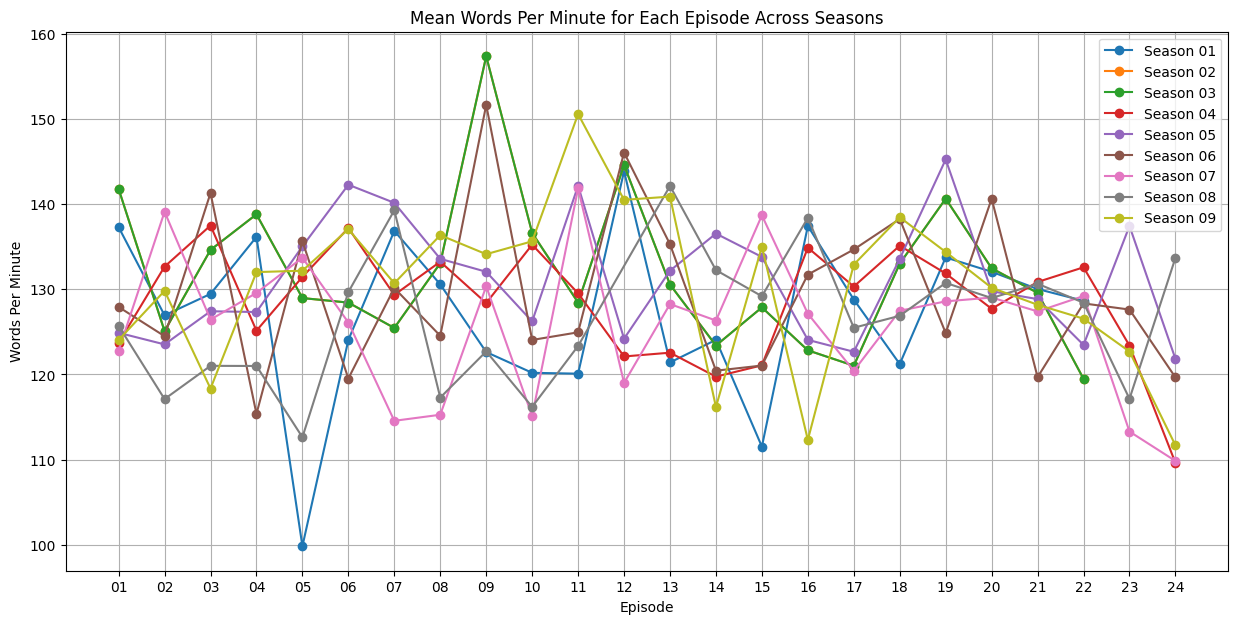

In [11]:
# Group by Season and Episode and calculate the mean for each episode
mean_wpm_per_episode = df_tseries.groupby(['Season', 'Episode']).mean().reset_index()

# Plotting the data
plt.figure(figsize=(15, 7))
for season in mean_wpm_per_episode['Season'].unique():
    season_data = mean_wpm_per_episode[mean_wpm_per_episode['Season'] == season]
    plt.plot(season_data['Episode'], season_data['Words Per Minute'], label=f'Season {season}', marker='o')

plt.title('Mean Words Per Minute for Each Episode Across Seasons')
plt.xlabel('Episode')
plt.ylabel('Words Per Minute')
plt.legend()
plt.grid(True)
plt.show()


Well pehaps if we were to plot the data throughout the first season we will would be able to remove some trend.

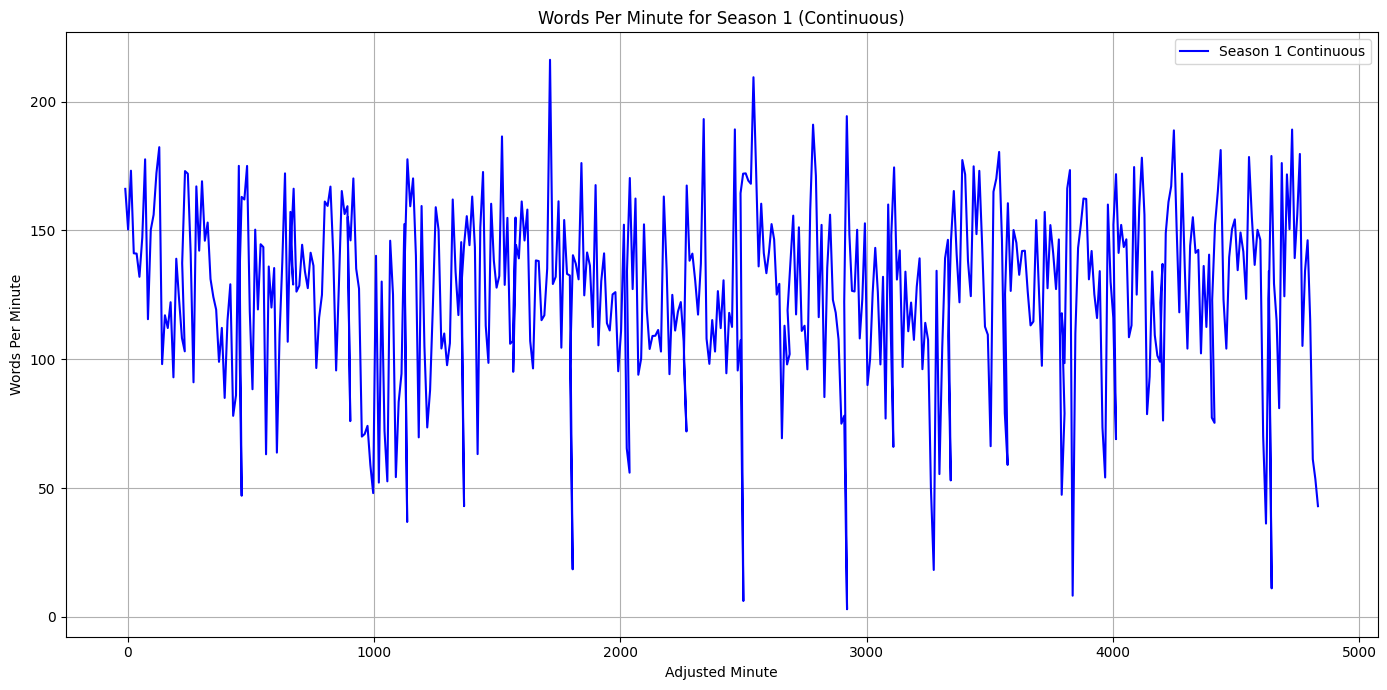

In [12]:
s1_data['Cumulative Max Minute'] = s1_data.groupby('Episode')['Minute'].transform('mean').cumsum()

# Adjust minute values to make episodes continuous
s1_data['Adjusted Minute'] = s1_data['Minute'] + s1_data['Cumulative Max Minute'] - s1_data['Minute'].max()

plt.figure(figsize=(14, 7))
plt.plot(s1_data['Adjusted Minute'], s1_data['Words Per Minute'], label='Season 1 Continuous', color='blue')

plt.title('Words Per Minute for Season 1 (Continuous)')
plt.xlabel('Adjusted Minute')
plt.ylabel('Words Per Minute')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


But nope! The model still very much taught there was not trend whatsoevee...

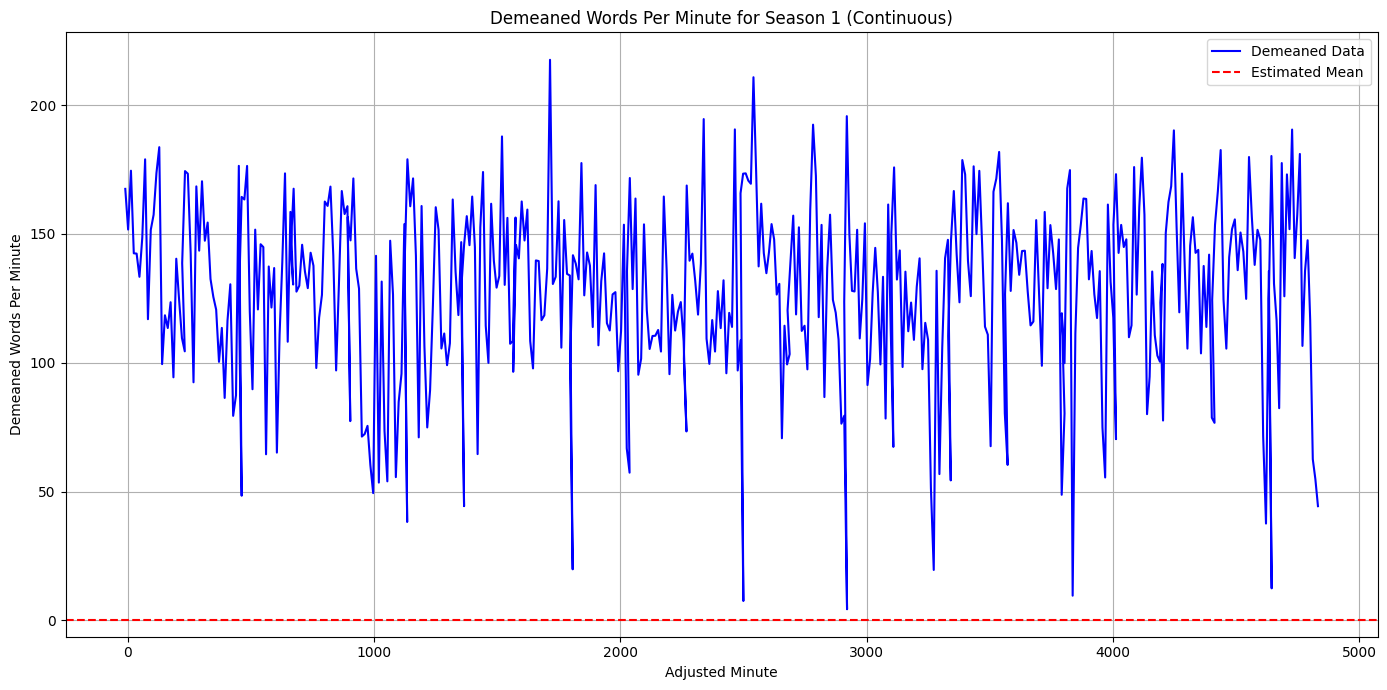

In [13]:
# Extracting the Words Per Minute values for Season 1 continuous data
data = s1_data['Words Per Minute'].values

# Using the ARIMA model with d=0 as a replacement for ARMA
ou_model = ARIMA(data, order=(1, 0, 0), trend='t').fit()

# Extracting the estimated mean from the OU process
mu = -ou_model.params[1] / (1 - ou_model.params[0])

# Demeaning the data
demeaned_data = data - mu

# Plotting the demeaned data
plt.figure(figsize=(14, 7))
plt.plot(s1_data['Adjusted Minute'], demeaned_data, label='Demeaned Data', color='blue')
plt.axhline(0, color='red', linestyle='--', label='Estimated Mean')
plt.title('Demeaned Words Per Minute for Season 1 (Continuous)')
plt.xlabel('Adjusted Minute')
plt.ylabel('Demeaned Words Per Minute')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Ok, well perhaps there is some curve that we can fit (or at least is seems so by eye). 

In [14]:
# Extracting the Words Per Minute values and the adjusted minute for Season 1 continuous data
x = s1_data['Adjusted Minute'].values
y = s1_data['Words Per Minute'].values

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Define a range for the polynomial degrees we want to test
degree_range = range(1, 16)

# Lists to store metrics for model evaluation
aic_list = []
bic_list = []
models = []
coefs = []

for degree in degree_range:
    # Create polynomial features
    poly = PolynomialFeatures(degree)
    x_poly_train = poly.fit_transform(x_train.reshape(-1, 1))
    x_poly_test = poly.transform(x_test.reshape(-1, 1))
    
    # Fit Lasso regression model
    lasso = LassoCV(cv=5, max_iter=10000).fit(x_poly_train, y_train)
    models.append(lasso)
    
    # Compute the residuals
    residuals = y_test - lasso.predict(x_poly_test)
    
    # Compute AIC and BIC
    num_params = np.sum(lasso.coef_ != 0) + 1  # Number of nonzero coefficients + intercept
    n = len(y_test)
    mse = np.mean(residuals**2)
    
    aic = n * np.log(mse) + 2 * num_params
    bic = n * np.log(mse) + np.log(n) * num_params
    
    aic_list.append(aic)
    bic_list.append(bic)
    coefs.append(lasso.coef_)

# Find the degree with the minimum AIC and BIC
best_degree_aic = degree_range[np.argmin(aic_list)]
best_degree_bic = degree_range[np.argmin(bic_list)]

print("Best Degree based on AIC:", best_degree_aic)
print("Best Degree based on BIC:", best_degree_bic)


Best Degree based on AIC: 8
Best Degree based on BIC: 8


Ha haaa! Best degree is 8!! Meaning we will be fiting a very nice (and definitely not a straight line) curve. We did it!

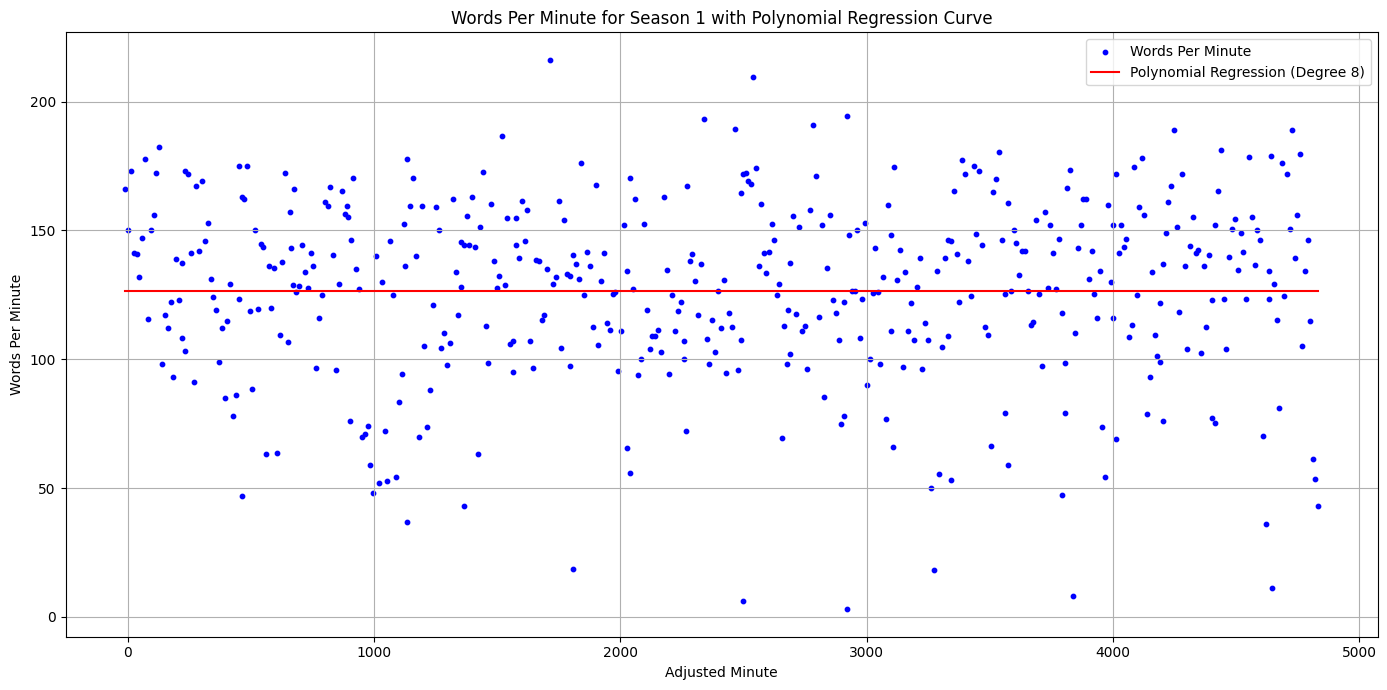

In [15]:


# Extracting the Words Per Minute values and the adjusted minute for Season 1 continuous data
x = s1_data['Adjusted Minute'].values
y = s1_data['Words Per Minute'].values

# Create polynomial features for the best degree (8 in this case)
poly = PolynomialFeatures(best_degree_aic)
x_poly = poly.fit_transform(x.reshape(-1, 1))

# Using the Lasso model for degree 8 to predict
y_pred = models[best_degree_aic-1].predict(x_poly)  # Index 7 corresponds to the 8th degree

# Plotting the data and the polynomial regression curve
plt.figure(figsize=(14, 7))
plt.scatter(x, y, color='blue', s=10, label='Words Per Minute')
plt.plot(x, y_pred, color='red', label=f'Polynomial Regression (Degree {best_degree_aic})')
plt.title('Words Per Minute for Season 1 with Polynomial Regression Curve')
plt.xlabel('Adjusted Minute')
plt.ylabel('Words Per Minute')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


... You are joking ...

At this point I got a bit stubborn for absolutely no reason ( I might or might not have said to the data "I will BREAK you"). It had nothing to do with the accuracy of my option pricing, I just had to force a curve through there. (spoiler alert, I even deleted the penalty term from the lasso regresson and it still wouldn't budge)

One last try, maybe throughout the seasons there is some trend we can use.

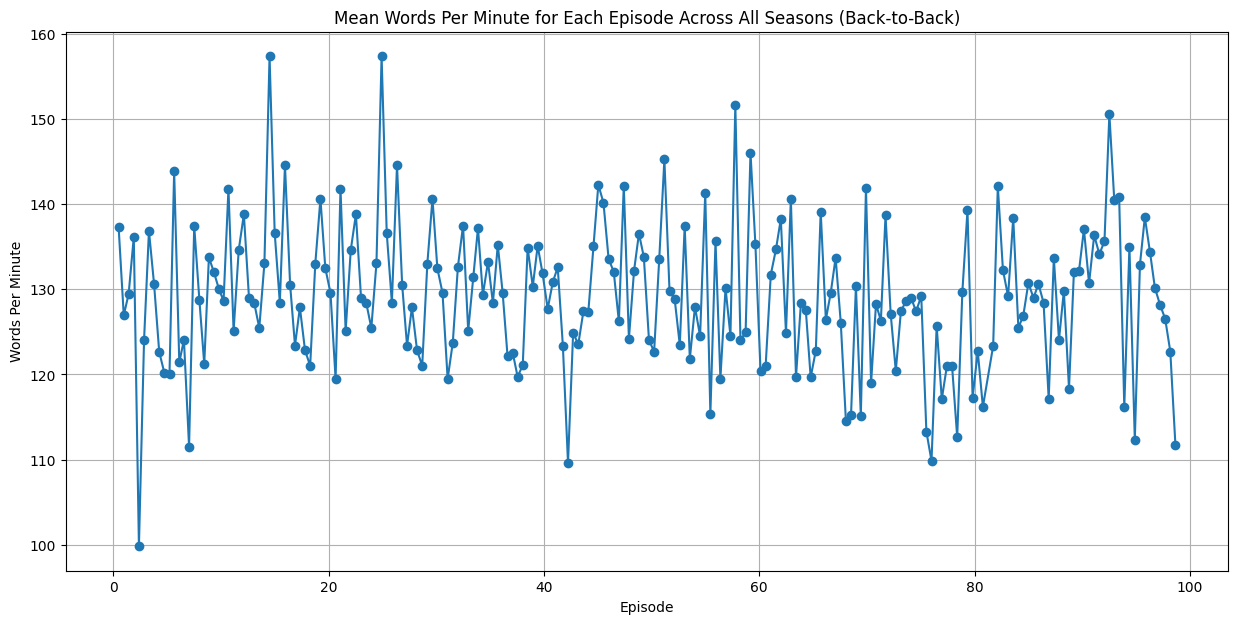

In [16]:
# Calculate a new 'Running Episode' column for the entire series
all_data_df = df_tseries
all_data_df['Running Episode'] = (all_data_df['Season'].astype(int) - 1) * 24 + all_data_df['Episode'].astype(int)

# Calculate the mean WPM for each episode
mean_wpm_per_running_episode = all_data_df.groupby('Running Episode').mean().reset_index()

# Calculate a cumulative sum of minutes for back-to-back episodes
mean_wpm_per_running_episode['Cumulative Minute'] = mean_wpm_per_running_episode['Minute'].cumsum()

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(mean_wpm_per_running_episode['Cumulative Minute']/22, mean_wpm_per_running_episode['Words Per Minute'], marker='o')

plt.title('Mean Words Per Minute for Each Episode Across All Seasons (Back-to-Back)')
plt.xlabel('Episode')
plt.ylabel('Words Per Minute')
plt.grid(True)
plt.show()

Ok you cannot tell me there is no way to fit a curve here, right?

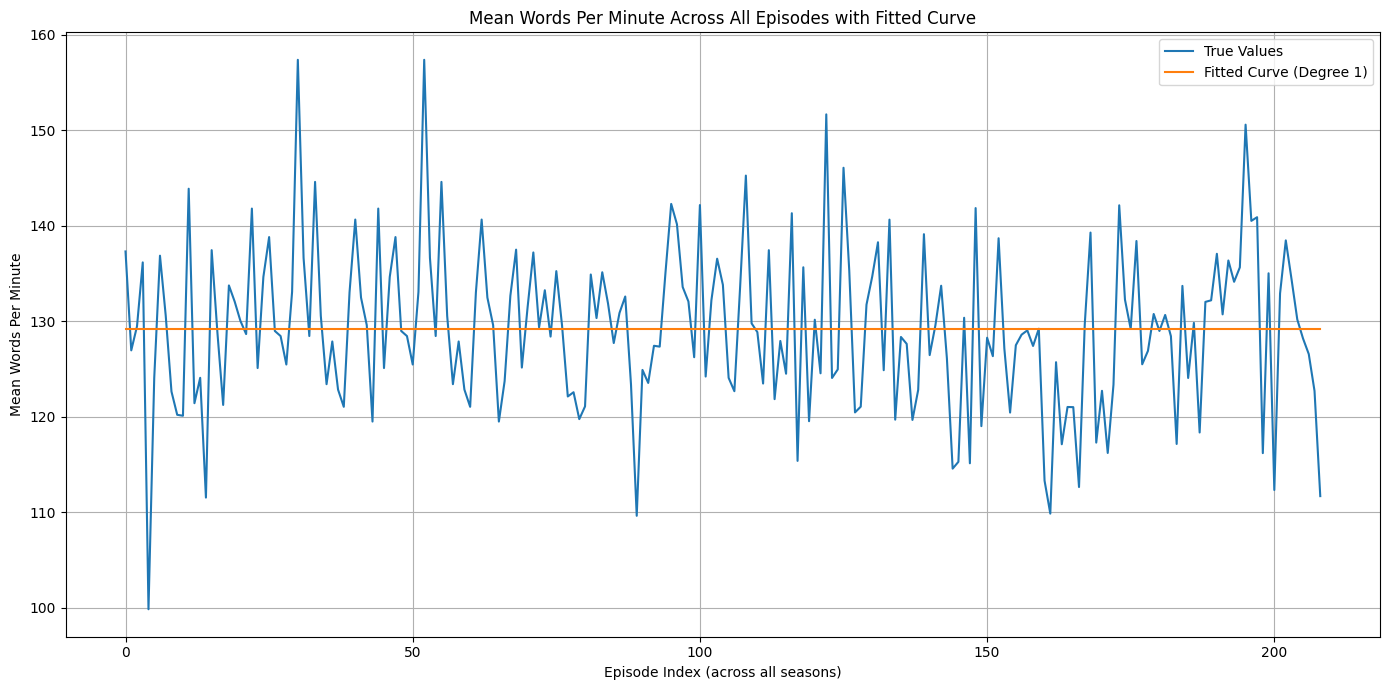

In [17]:
# Defining the X and y data
X = mean_wpm_per_episode.index.values.reshape(-1, 1)
y = mean_wpm_per_episode['Words Per Minute'].values

# Splitting the data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining the range of degrees we want to test
degrees = list(range(1, 15))

aic_values = []

for degree in degrees:
    model = make_pipeline(PolynomialFeatures(degree), LassoCV(max_iter=100000))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mse = np.mean((y_val- y_pred) ** 2)
    aic = len(y_val) * np.log(mse) + 2 * (degree + 1)
    aic_values.append(aic)

# Identifying the best degree
best_degree = degrees[np.argmin(aic_values)]

# Using the previously determined degree to fit the polynomial to the entire dataset
model = make_pipeline(PolynomialFeatures(best_degree), LassoCV())
model.fit(X, y)
y_pred = model.predict(X)

# Plotting the values and the fitted curve
plt.figure(figsize=(14, 7))
plt.plot(X, y, '-', label="True Values", markersize=5)
plt.plot(X, y_pred, '-', label=f"Fitted Curve (Degree {best_degree})")
plt.xlabel("Episode Index (across all seasons)")
plt.ylabel("Mean Words Per Minute")
plt.legend()
plt.title("Mean Words Per Minute Across All Episodes with Fitted Curve")
plt.grid(True)
plt.tight_layout()
plt.show()


\*throws computer at the wall\*

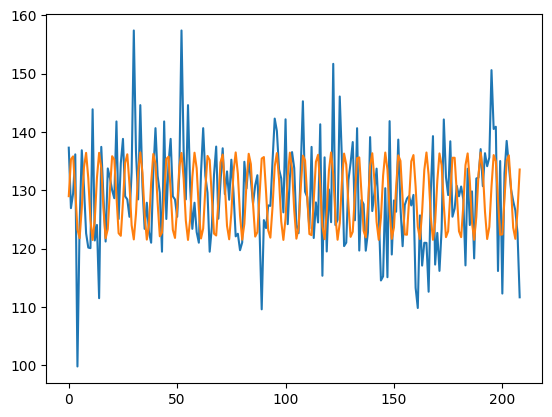

In [18]:
plt.plot(X, y, '-')
plt.plot(X, 129+7.5*np.sin(X), '-')
plt.show()


better.

## Part IV: Option Pricing

Ok, jokes aside let's do some of the option pricing.

Based on the modeled WPM data, we will do call pricing based on the Black-Sholes model and infer put prices with the put-call parity. We will interpret the episodes as trading days (i.e. the point in time) and we will set the current point in time by the `episode` variable.

In [19]:
def black_scholes_call(S_0, X, t, r, q, sigma):
    d1 = (np.log(S_0 / X) + (r - q + sigma**2 / 2) * t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    
    C = S_0 * np.exp(-q * t) * norm.cdf(d1) - X * np.exp(-r * t) * norm.cdf(d2)
    return max(C,min_tc)

In [20]:
def black_scholes_greeks(S_0, X, t, r, q, sigma):
    d1 = (np.log(S_0 / X) + (r - q + sigma**2 / 2) * t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    
    # Calculate call option price
    C = S_0 * np.exp(-q * t) * norm.cdf(d1) - X * np.exp(-r * t) * norm.cdf(d2)
    
    # Delta for call and put
    delta_call = np.exp(-q * t) * norm.cdf(d1)
    delta_put = np.exp(-q * t) * (norm.cdf(d1) - 1)
    
    # Gamma (same for both call and put)
    gamma = (np.exp(-q * t) * norm.pdf(d1)) / (S_0 * sigma * np.sqrt(t))
    
    return C, delta_call, delta_put, gamma

In [21]:
# Mock values
r = 0.02 # risk-free rate
q = 0 # dividend yield
t = 1  # default time to expiration
min_tc = 0.01 # minimum transaction cost or (the minimum price)
episode = 100 # i.e. current point in time
range_of_options = .6 
# how wide do we want the sepcter of options offered to be e.g. now it will go between 60% and 140% of current price

In [25]:
sigma = y[0:episode-1].std()/100
S_0 = y[episode-1]
print('S_0:   ', round(S_0,3))
print('sigma: ', round(sigma,3))
print('cutoff:', round(min_tc,3))

# Calculate call option prices and Greeks for a range of strike prices
call_prices = []
delta_calls = []
delta_puts = []
gammas = []

# Range of strike prices
strike_prices = np.floor(np.arange(S_0*range_of_options, S_0*(2-range_of_options), 5))

for X in strike_prices:
    C, delta_call, delta_put, gamma = black_scholes_greeks(S_0, X, t, r, q, sigma)
    call_prices.append(C)
    delta_calls.append(delta_call)
    delta_puts.append(delta_put)
    gammas.append(gamma)

# Calculate put prices
put_prices = [max(call + X * np.exp(-r * t) - S_0, min_tc) for call, X in zip(call_prices, strike_prices)]

# Compile data into a DataFrame
df_call_prices = pd.DataFrame({
    'Strike Price': np.round(strike_prices,3), 
    'Call Price': np.round(call_prices,3), 
    'Put Price': np.round(put_prices,3),
    'Delta (Call)': np.round(delta_calls, 3),
    'Delta (Put)': np.round(delta_puts, 3),
    'Gamma': np.round(gammas, 3)
})

df_call_prices



S_0:    126.227
sigma:  0.084
cutoff: 0.01


,Strike Price,Call Price,Put Price,Delta (Call),Delta (Put),Gamma
0,75.0,52.712,0.010,1.000,-0.000,0.000
1,80.0,47.811,0.010,1.000,-0.000,0.000
2,85.0,42.910,0.010,1.000,-0.000,0.000
3,90.0,38.009,0.010,1.000,-0.000,0.000
4,95.0,33.108,0.010,1.000,-0.000,0.000
5,100.0,28.210,0.010,0.999,-0.001,0.000
6,105.0,23.330,0.024,0.993,-0.007,0.002
7,110.0,18.522,0.117,0.972,-0.028,0.006
8,115.0,13.920,0.416,0.917,-0.083,0.014
9,120.0,9.755,1.152,0.811,-0.189,0.025
